In [84]:
import os
import sys
import importlib
AbsPath = str(os.path.abspath(""))+"/../.."
sys.path.append(AbsPath)
import numpy as np
import matplotlib.pyplot as plt
import colossus.halo.mass_adv as massdefs
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology("planck15")
Cosmo =cosmology.getCurrent()
h = Cosmo.h
h_3 = h*h*h

In [4]:
from Scripts import SMHM_Fit_MCMC
HMF_Class = SMHM_Fit_MCMC.HaloMassFunction()

In [76]:
SubHalosByAcc = HMF_Class.SHMF_STEEL(0.104)
#DM_Masses = (massdefs.changeMassDefinitionCModel(np.power(10, SubHalosByAcc[0]+np.log10(h)), 0.1, "vir", "200c")[0], SubHalosByAcc[1], SubHalosByAcc[2])
DM_Masses = np.power(10, SubHalosByAcc[0]+np.log10(h))
CentralHalos = mass_function.massFunction(DM_Masses, 0.1, mdef = "vir", model = 'tinker08', q_out='dndlnM')*np.log(10)

In [77]:
print(np.shape(SubHalosByAcc[0]))
print(np.shape(SubHalosByAcc[1]))
print(np.shape(SubHalosByAcc[2]))

(65,)
(190, 65)
(190,)


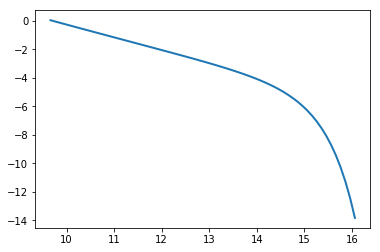

In [108]:
plt.plot(np.log10(DM_Masses), np.log10(CentralHalos))

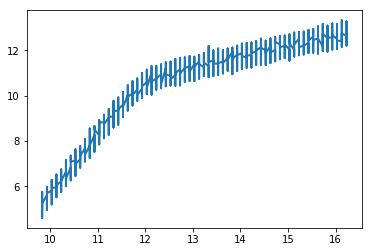

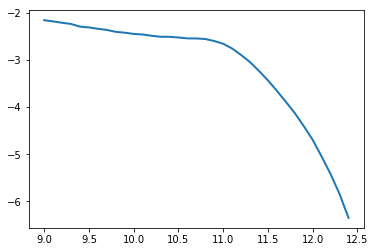

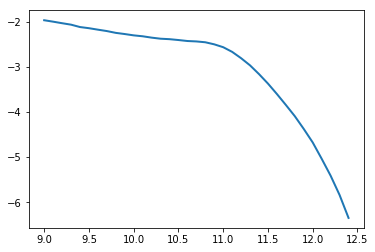

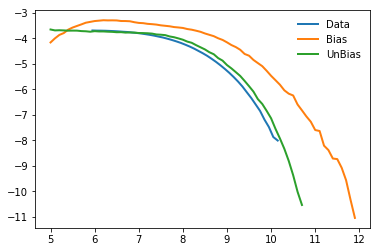

In [133]:
SMF_Bin = 0.1
HMF_Bin = 0.1
SMF_X = np.arange(9, 12.5, SMF_Bin)

M10, SHMnorm10, beta10, gamma10,M11,SHMnorm11,beta11,gamma11, Scatter = 11.925, 0.032,1.639,0.532,0.576,-0.014,-0.693,0.03,0.15
z = 0.1
zparameter = np.divide(z-0.1, z+1)
#putting the parameters together for inclusion in the Moster 2010 equation
M = M10 + M11*zparameter
N = SHMnorm10 + SHMnorm11*zparameter
b = beta10 + beta11*zparameter
g = gamma10 + gamma11*zparameter

DM = SubHalosByAcc[0]
Wt = CentralHalos

N_rep = 5000

DM = np.repeat(SubHalosByAcc[0], N_rep) #log Mh [Msun]
Wt = np.repeat(np.divide(CentralHalos*h_3*HMF_Bin, N_rep), N_rep) #Phi/N [Mpc^-3]

SM = np.log10(np.power(10, DM) * (2*N*np.power( (np.power(np.power(10,DM-M), -b) + np.power(np.power(10,DM-M), g)), -1))) + np.random.normal(0, Scatter, size = np.shape(DM))
plt.plot(DM, SM)
plt.show()
SMF_Total = np.histogram(SM, bins = np.append(SMF_X, SMF_X[-1]+SMF_Bin)-(SMF_Bin/2), weights = Wt, density = False)[0]

plt.plot(SMF_X, np.log10(np.divide(SMF_Total, SMF_Bin)))
plt.show()

for i, z in enumerate(SubHalosByAcc[2]):
    #print(z)
    Wt = np.repeat(np.divide(SubHalosByAcc[1][i]*h_3*HMF_Bin, N_rep ), N_rep) #Phi/N [Mpc^-3]
    #print(Wt)
    zparameter = np.divide(z-0.1, z+1)
    #putting the parameters together for inclusion in the Moster 2010 equation
    M = M10 + M11*zparameter
    N = SHMnorm10 + SHMnorm11*zparameter
    b = beta10 + beta11*zparameter
    g = gamma10 + gamma11*zparameter
    
    SM =  np.log10(np.power(10, DM) * (2*N*np.power( (np.power(np.power(10,DM-M), -b) + np.power(np.power(10,DM-M), g)), -1))) + np.random.normal(0, Scatter, size = np.shape(DM))
    SMF_Y = np.histogram(SM, bins = np.append(SMF_X, SMF_X[-1]+SMF_Bin)-(SMF_Bin/2), weights = Wt, density = False)[0]
    SMF_Total = SMF_Total+SMF_Y


    
plt.plot(SMF_X, np.log10(np.divide(SMF_Total, SMF_Bin)))
plt.show()



SM_X = np.repeat(SMF_X, N_rep)
SM_Y = np.repeat(np.divide(SMF_Total*SMF_Bin, N_rep), N_rep)

BH_Bin = 0.1
BH_X = np.arange(5, 12, 0.1)

BH_Y_Bias = np.histogram(Ms_to_Mbh_biased(SM_X), bins = np.append(BH_X, BH_X[-1]+BH_Bin)-(BH_Bin/2), weights = SM_Y, density = False)[0]
BH_Y_Intr = np.histogram(Ms_to_Mbh_intrisic(SM_X), bins = np.append(BH_X, BH_X[-1]+BH_Bin)-(BH_Bin/2), weights = SM_Y, density = False)[0]

BH_MF_Data = np.loadtxt(AbsPath+"/Data/Observational/Francesco/BHmassFunction.txt", skiprows = 2).T
plt.plot(BH_MF_Data[0], BH_MF_Data[1]+np.log10(0.1), label = "Data")

plt.plot(BH_X, np.log10(np.divide(BH_Y_Bias,BH_Bin)), label = "Bias")
plt.plot(BH_X, np.log10(np.divide(BH_Y_Intr,BH_Bin)), label = "UnBias")

plt.legend(frameon = False)
plt.show()

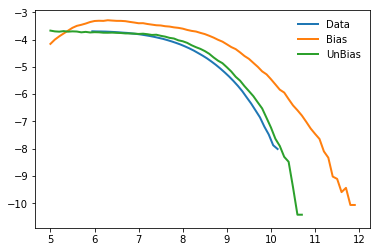

In [134]:
SM_X = np.repeat(SMF_X, N_rep)
SM_Y = np.repeat(np.divide(SMF_Total*SMF_Bin, N_rep), N_rep)

BH_Bin = 0.1
BH_X = np.arange(5, 12, 0.1)

BH_Y_Bias = np.histogram(Ms_to_Mbh_biased(SM_X), bins = np.append(BH_X, BH_X[-1]+BH_Bin)-(BH_Bin/2), weights = SM_Y, density = False)[0]
BH_Y_Intr = np.histogram(Ms_to_Mbh_intrisic(SM_X), bins = np.append(BH_X, BH_X[-1]+BH_Bin)-(BH_Bin/2), weights = SM_Y, density = False)[0]

BH_MF_Data = np.loadtxt(AbsPath+"/Data/Observational/Francesco/BHmassFunction.txt", skiprows = 2).T
plt.plot(BH_MF_Data[0], BH_MF_Data[1]+np.log10(0.1), label = "Data")

plt.plot(BH_X, np.log10(np.divide(BH_Y_Bias,BH_Bin)), label = "Bias")
plt.plot(BH_X, np.log10(np.divide(BH_Y_Intr,BH_Bin)), label = "UnBias")

plt.legend(frameon = False)
plt.show()

In [115]:
def Ms_to_Mbh_biased(Mstar):
    #Function to map Mbh to M*
    #Args:
    #    Mstar [log10 Msun]
    #Return:
    #    Mbh [log10 Msun]
    return 8.35+1.31*(Mstar-11) + np.random.normal(0, 0.5, size = np.shape(Mstar))
def Ms_to_Mbh_intrisic(Mstar):
    #Function to map Mbh to M*
    #Args:
    #    Mstar [log10 Msun]
    #Return:
    #    Mbh [log10 Msun]
    Mass = 7.574 + 1.946*(Mstar-11) - 0.306*np.power(Mstar-11,2) - 0.011*np.power(Mstar-11,3)
    Scatter = 0.32 - 0.1*(Mstar-12)
    return Mass + np.random.normal(0, Scatter, size = np.shape(Mstar))